In [1]:
from time import time
import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import optax
import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import matplotlib.pyplot as plt
import seaborn as sns

from bijax import ADVI, MCMC
from bijax.utils import train_fn

import pymc as pm
import numpy as np
import arviz as az

import numpy as np
from sklearn.datasets import make_moons
from tinygp import GaussianProcess, kernels

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


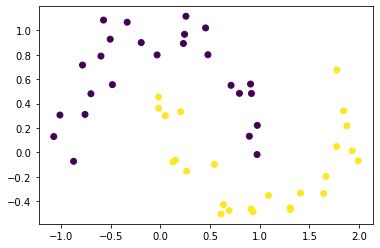

In [2]:
x, y = make_moons(n_samples=50, shuffle=True, noise=0.1, random_state=1)
plt.scatter(x[: ,0], x[:, 1], c=y);

## Model

In [3]:
kernel = kernels.ExpSquared()
gp = GaussianProcess(kernel, x)

In [4]:
def get_gp_sample(latent_sample, inputs):
    scale = jnp.exp(latent_sample['scale'])
    scaled_inputs = inputs/scale
    gp_kernel = jnp.exp(latent_sample['var']) * kernels.ExpSquared(scale=1.0)
    cov = gp_kernel(scaled_inputs, scaled_inputs)
    gp = GaussianProcess(gp_kernel, scaled_inputs)
    chol = jnp.linalg.cholesky(gp.covariance)
    f_sample = latent_sample['mean'] + chol@latent_sample['epsilon']
    return f_sample, gp

def log_likelihood_fn(latent_sample, outputs, inputs, **kwargs):
    f_sample, gp = get_gp_sample(latent_sample, inputs)
    likelihood = tfd.Bernoulli(logits=f_sample)
    return likelihood.log_prob(outputs).sum()

def get_model1():
    prior = {'scale': tfd.LogNormal([0.0, 0.0], [1.0, 1.0]), 
             'var': tfd.LogNormal(0.0, 1.0), 
             'mean': tfd.Normal(0.0, 1.0), 
             'epsilon':tfd.MultivariateNormalDiag(loc=jnp.zeros(len(y)), scale_diag=jnp.ones(len(y)))}
    bijector = {'scale': tfb.Exp(), 'var': tfb.Exp()}
    return prior, bijector

prior, bijector = get_model1()

## MCMC

In [ ]:
mcmc = MCMC(prior, bijector, log_likelihood_fn)
kernel = mcmc.get_nuts_kernel(outputs=y, inputs=x, step_size=1e-3)

seed = jax.random.PRNGKey(9)
init_params = mcmc.init(seed)
init_params
seed = jax.random.PRNGKey(10)
init = time()
n_burnin = 3000
n_samples = 5000
samples, log_probs = mcmc.sample(seed=seed, init_params_pytree=init_params, kernel=kernel, n_burnin=n_burnin, n_samples=n_samples)
print((time() - init)/60, 'minutes')

In [ ]:
eps = 1
n = 100
x0, x1 = np.meshgrid(np.linspace(x[:, 0].min()-eps, x[:, 0].max()+eps, n),
                         np.linspace(x[:, 1].min()-eps, x[:, 1].max()+eps, n))

x_test = jnp.array([(xi, xj) for xi, xj in zip(x0.ravel(), x1.ravel())])

def get_predictive_samples(seed, sample):
    f_sample, gp = get_gp_sample(latent_sample=sample, inputs=x)
    f_loc = gp.condition(f_sample, x_test).gp.loc
#     return jax.nn.sigmoid(f_loc)
    likelihood = tfd.Bernoulli(logits=f_loc)
    return likelihood.sample(seed=seed)

seeds = jax.random.split(seed, num=n_samples)
init = time()
y_pred = jax.jit(jax.vmap(get_predictive_samples))(seeds, samples)
print((time() - init)/60, 'minutes')
y_pred_mean = y_pred.mean(axis=0).reshape(n, n)
y_pred_std = y_pred.std(axis=0).reshape(n, n)
y_pred_mean.shape, y_pred_std.shape

In [ ]:
def plot_data(x, y, **kwargs):
    colors = np.array(['blue', 'red'])
    plt.scatter(x[:, 0], x[:, 1], c=colors[y], **kwargs)

def plot_uq(sample_mean, sample_std, figsize=np.array([8, 3]), grid_eps=0.5):
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.contourf(x0, x1, sample_mean, 101,
                cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.title(f'Posterior Mean function')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
    plot_data(x, y, edgecolor="orange")

    plt.subplot(1, 2, 2)
    plt.contourf(x0, x1, sample_std, 101,
                cmap=plt.get_cmap('Oranges'), vmin=0)
    plt.title(f'Posterior SD function')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
    plot_data(x, y, edgecolor="black")
    plt.tight_layout()

In [ ]:
plot_uq(y_pred_mean, y_pred_std);

## ADVI

In [ ]:
advi = ADVI(prior, bijector, log_likelihood_fn, vi_type='mean_field')

In [ ]:
seed = jax.random.PRNGKey(0)
optimizer = optax.adam(learning_rate=0.0001)
params = advi.init(seed=seed)
seed = jax.random.PRNGKey(1)

# print(params['posterior'].mean(), params['posterior'].variance())

loss_fn = jax.tree_util.Partial(advi.loss_fn, outputs=y, inputs=x, full_data_size=len(y))
log_likelihood_fn(params['posterior'].sample(seed=seed), y, x)
# print(params)
# loss_fn(params, seed=seed)
# result = train_fn(loss_fn, params, optimizer, n_epochs=1000, seed=seed, return_args=['losses'])
# plt.plot(result['losses']);

In [ ]:
advi_posterior = advi.apply(result['params'])

In [ ]:
import lab.jax as B
import matplotlib.pyplot as plt
from varz.jax import Vars, minimise_l_bfgs_b, parametrised, Positive
from wbml.plot import tweak

from stheno.jax import EQ, GP

# Increase regularisation because PyTorch defaults to 32-bit floats.
B.epsilon = 1e-6

# Define points to predict at.
x = np.linspace(0, 2, 100)
x_obs = np.linspace(0, 2, 50)

# Sample a true, underlying function and observations with observation noise `0.05`.
f_true = np.sin(5 * x)
y_obs = np.sin(5 * x_obs) + 0.05**0.5 * np.random.normal((50, ))


def model(vs):
    """Construct a model with learnable parameters."""
    p = vs.struct  # Varz handles positivity (and other) constraints.
    kernel = p.variance.positive() * EQ().stretch(p.scale.positive())
    return GP(kernel), p.noise.positive()


@parametrised
def model_alternative(vs, scale: Positive, variance: Positive, noise: Positive):
    """Equivalent to :func:`model`, but with `@parametrised`."""
    kernel = variance * EQ().stretch(scale)
    return GP(kernel), noise


vs = Vars(jnp.float32)
f, noise = model(vs)

# Condition on observations and make predictions before optimisation.
f_post = f | (f(x_obs, noise), y_obs)
prior_before = f, noise
pred_before = f_post(x, noise).marginal_credible_bounds()


def objective(x, y):
    f, noise = model(vs)
    evidence = f(x, noise).logpdf(y)
    return -evidence

In [ ]:
objective(x_obs, y_obs)